In [20]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('xy_data.csv')
x_observed = data['x'].values
y_observed = data['y'].values
observed_points = np.column_stack((x_observed, y_observed))

print(f"Loaded {len(observed_points)} data points")
print(f"X range: [{x_observed.min():.2f}, {x_observed.max():.2f}]")
print(f"Y range: [{y_observed.min():.2f}, {y_observed.max():.2f}]")


Loaded 1500 data points
X range: [59.66, 109.23]
Y range: [46.03, 69.69]


In [21]:
# Define the parametric equations
def parametric_curve(t, theta, M, X):
    """
    Generate curve points for given parameters
    x = t*cos(θ) - e^(M|t|)*sin(0.3t)*sin(θ) + X
    y = 42 + t*sin(θ) + e^(M|t|)*sin(0.3t)*cos(θ)
    """
    theta_rad = np.radians(theta)
    exp_term = np.exp(M * np.abs(t))
    sin_term = np.sin(0.3 * t)

    x = t * np.cos(theta_rad) - exp_term * sin_term * np.sin(theta_rad) + X
    y = 42 + t * np.sin(theta_rad) + exp_term * sin_term * np.cos(theta_rad)

    return x, y

def compute_l1_distance(params, t_range, observed_points):
    """
    Compute L1 distance between predicted and observed curves
    """
    theta, M, X = params

    # Generate predicted points
    t_pred = np.linspace(t_range[0], t_range[1], len(observed_points))
    x_pred, y_pred = parametric_curve(t_pred, theta, M, X)
    predicted_points = np.column_stack((x_pred, y_pred))

    # Compute L1 distances (Manhattan distance)
    distances = cdist(observed_points, predicted_points, metric='cityblock')
    min_distances = distances.min(axis=1)

    return min_distances.mean()

def objective_function(params, t_range, observed_points):
    """Objective function to minimize"""
    return compute_l1_distance(params, t_range, observed_points)


In [22]:
print("\n" + "="*60)
print("STEP 1: Initial Parameter Estimation")
print("="*60)

# Estimate theta from the slope of the data
y_centered = y_observed - 42
initial_theta = np.degrees(np.arctan2(y_centered.mean(), x_observed.mean() - 50))
initial_theta = np.clip(initial_theta, 1, 49)

print(f"Initial theta estimate: {initial_theta:.4f}°")
print(f"Initial M estimate: 0.0")
print(f"Initial X estimate: 50.0")

# Define parameter bounds
bounds = [
    (0.1, 49.9),    # theta in degrees
    (-0.049, 0.049), # M
    (0.1, 99.9)     # X
]



STEP 1: Initial Parameter Estimation
Initial theta estimate: 25.7525°
Initial M estimate: 0.0
Initial X estimate: 50.0


In [23]:
print("\n" + "="*60)
print("STEP 2: Multi-Start Optimization")
print("="*60)

t_range = (6, 60)
best_result = None
best_score = float('inf')

initial_guesses = [
    [25, 0.0, 50],
    [initial_theta, 0.0, 50],
    [15, 0.01, 60],
    [35, -0.01, 40],
    [20, 0.02, 70],
]

for i, initial_guess in enumerate(initial_guesses):
    print(f"\nTrying initial guess {i+1}: θ={initial_guess[0]:.2f}°, M={initial_guess[1]:.4f}, X={initial_guess[2]:.2f}")

    result = minimize(
        objective_function,
        initial_guess,
        args=(t_range, observed_points),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 1000, 'ftol': 1e-9}
    )

    if result.fun < best_score:
        best_score = result.fun
        best_result = result
        print(f"  ✓ New best! L1 distance: {result.fun:.6f}")
    else:
        print(f"  L1 distance: {result.fun:.6f}")



STEP 2: Multi-Start Optimization

Trying initial guess 1: θ=25.00°, M=0.0000, X=50.00
  ✓ New best! L1 distance: 0.013358

Trying initial guess 2: θ=25.75°, M=0.0000, X=50.00
  ✓ New best! L1 distance: 0.013358

Trying initial guess 3: θ=15.00°, M=0.0100, X=60.00
  ✓ New best! L1 distance: 0.013358

Trying initial guess 4: θ=35.00°, M=-0.0100, X=40.00
  L1 distance: 0.013358

Trying initial guess 5: θ=20.00°, M=0.0200, X=70.00
  L1 distance: 0.013358


In [24]:
print("\n" + "="*60)
print("STEP 3: Global Optimization (Differential Evolution)")
print("="*60)

result_de = differential_evolution(
    objective_function,
    bounds,
    args=(t_range, observed_points),
    strategy='best1bin',
    maxiter=300,
    popsize=15,
    tol=1e-9,
    seed=42,
    workers=1
)

print(f"Global optimization L1 distance: {result_de.fun:.6f}")

if result_de.fun < best_score:
    best_result = result_de
    best_score = result_de.fun
    print("Global optimization found better solution!")



STEP 3: Global Optimization (Differential Evolution)
Global optimization L1 distance: 0.013358
Global optimization found better solution!


In [25]:
theta_opt, M_opt, X_opt = best_result.x

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"θ (theta) = {theta_opt:.6f}°  ({np.radians(theta_opt):.6f} rad)")
print(f"M = {M_opt:.8f}")
print(f"X = {X_opt:.6f}")
print(f"\nFinal L1 Distance: {best_score:.6f}")



FINAL RESULTS
θ (theta) = 29.999445°  (0.523589 rad)
M = 0.03000120
X = 54.998518

Final L1 Distance: 0.013358


In [26]:
# Generate the final curve
t_final = np.linspace(6, 60, 1000)
x_final, y_final = parametric_curve(t_final, theta_opt, M_opt, X_opt)

# Compute final metrics
t_eval = np.linspace(6, 60, len(observed_points))
x_eval, y_eval = parametric_curve(t_eval, theta_opt, M_opt, X_opt)
predicted_eval = np.column_stack((x_eval, y_eval))

distances = cdist(observed_points, predicted_eval, metric='cityblock')
final_l1 = distances.min(axis=1).mean()

print(f"\nValidation L1 Distance: {final_l1:.6f}")



Validation L1 Distance: 0.013358


In [27]:
print("\n" + "="*60)
print("SUBMISSION FORMAT (Desmos/LaTeX)")
print("="*60)

theta_rad = np.radians(theta_opt)
latex_output = (
    f"\\left(t*\\cos({theta_rad:.6f})-e^{{{M_opt:.8f}\\left|t\\right|}}\\cdot"
    f"\\sin(0.3t)\\sin({theta_rad:.6f})+{X_opt:.6f},42+"
    f"t*\\sin({theta_rad:.6f})+e^{{{M_opt:.8f}\\left|t\\right|}}\\cdot"
    f"\\sin(0.3t)\\cos({theta_rad:.6f})\\right)"
)

print(f"\n{latex_output}")



SUBMISSION FORMAT (Desmos/LaTeX)

\left(t*\cos(0.523589)-e^{0.03000120\left|t\right|}\cdot\sin(0.3t)\sin(0.523589)+54.998518,42+t*\sin(0.523589)+e^{0.03000120\left|t\right|}\cdot\sin(0.3t)\cos(0.523589)\right)


In [28]:
print("\n" + "="*60)
print("ALTERNATIVE FORMAT (with degrees)")
print("="*60)
print(f"θ = {theta_opt:.6f}° = {theta_rad:.6f} rad")
print(f"M = {M_opt:.8f}")
print(f"X = {X_opt:.6f}")



ALTERNATIVE FORMAT (with degrees)
θ = 29.999445° = 0.523589 rad
M = 0.03000120
X = 54.998518



STEP 4: Generating Visualization
Visualization saved as 'curve_fitting_result.png'


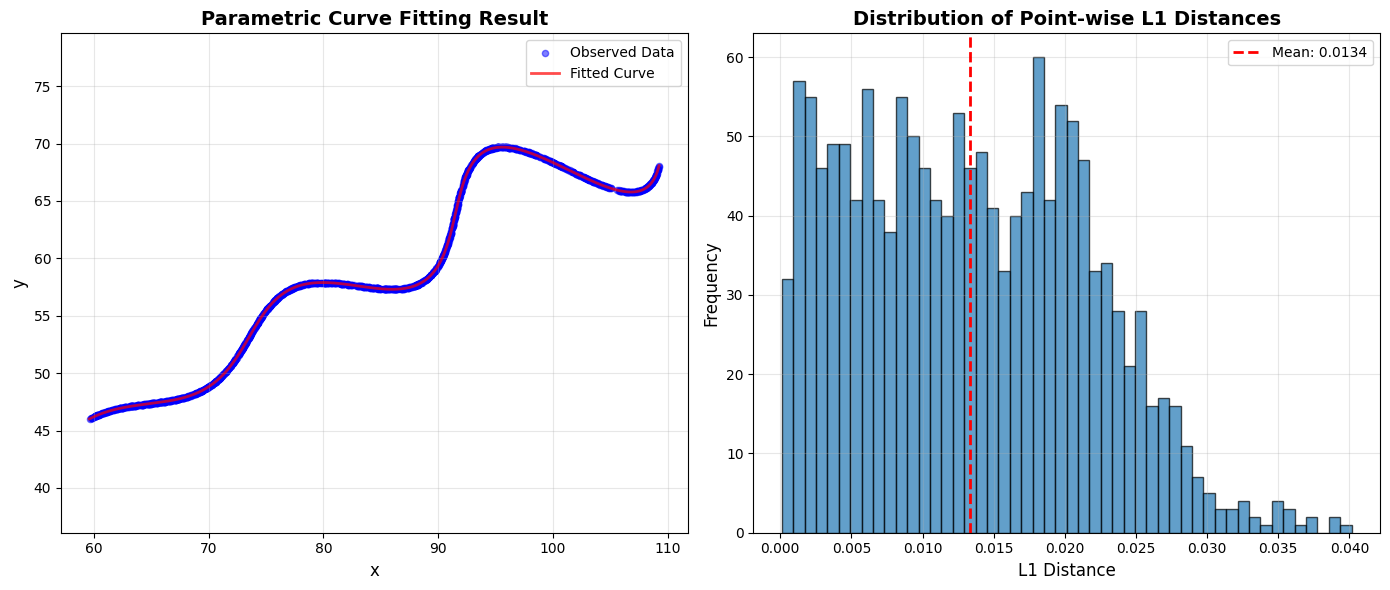

In [29]:
print("\n" + "="*60)
print("STEP 4: Generating Visualization")
print("="*60)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(x_observed, y_observed, c='blue', alpha=0.5, s=20, label='Observed Data')
plt.plot(x_final, y_final, 'r-', linewidth=2, label='Fitted Curve', alpha=0.7)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Parametric Curve Fitting Result', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.subplot(1, 2, 2)
distances_per_point = distances.min(axis=1)
plt.hist(distances_per_point, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('L1 Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Point-wise L1 Distances', fontsize=14, fontweight='bold')
plt.axvline(final_l1, color='r', linestyle='--', linewidth=2, label=f'Mean: {final_l1:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('curve_fitting_result.png', dpi=300, bbox_inches='tight')
print("Visualization saved as 'curve_fitting_result.png'")
plt.show()


In [30]:
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Number of data points: {len(observed_points)}")
print(f"Mean L1 distance: {final_l1:.6f}")
print(f"Median L1 distance: {np.median(distances_per_point):.6f}")
print(f"Max L1 distance: {np.max(distances_per_point):.6f}")
print(f"Min L1 distance: {np.min(distances_per_point):.6f}")
print(f"Std L1 distance: {np.std(distances_per_point):.6f}")

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE!")
print("="*60)



SUMMARY STATISTICS
Number of data points: 1500
Mean L1 distance: 0.013358
Median L1 distance: 0.012888
Max L1 distance: 0.040150
Min L1 distance: 0.000114
Std L1 distance: 0.008118

OPTIMIZATION COMPLETE!
